In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import a_mps as mps
import b_model as tfi
import c_tebd as tebd
import tfi_exact

In [127]:
def init_spinupX_MPS(L):
    """Return a product state of |+> as an MPS"""
    B = np.zeros([1, 2, 1], np.float)
    B[0, :, 0] = 1./np.sqrt(2)
    S = np.ones([1], np.float)
    Bs = [B.copy() for i in range(L)]
    Ss = [S.copy() for i in range(L)]
    return mps.MPS(Bs, Ss)

In [136]:
L = 14
mps_spinup = mps.init_spinup_MPS(L)
mps_spinupX = init_spinupX_MPS(L)

Sz = [[1,0],[0,-1]]
Sx = [[0,1],[1,0]]
Ex1 = mps_spinup.site_expectation_value(Sx)
Ez1 = mps_spinup.site_expectation_value(Sz)
entropy1 = mps_spinup.entanglement_entropy()
print(Ez1, Ex1, entropy1, '', sep='\n')

Ez2 = mps_spinupX.site_expectation_value(Sz)
Ex2 = mps_spinupX.site_expectation_value(Sx)
entropy2 = mps_spinupX.entanglement_entropy()
print(Ez2, Ex2, entropy2, sep='\n')

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]


In [137]:
J = 1
gs = [0.5, 1, 1.5]
tising = [tfi.TFIModel(L, J, g) for g in gs]

Ezs = [model.energy(mps_spinup) for model in tising]
Exs = [model.energy(mps_spinupX) for model in tising]

print(Ezs, np.round(Exs,3), sep='\n')

[-7.0, -14.0, -21.0]
[-13. -13. -13.]


In [10]:
tebd.example_TEBD_gs_finite(L, J, gs[2])

finite TEBD, (imaginary time evolution)
L=14, J=1.0, g=1.50
dt = 0.10000: E = -23.1210722544100
dt = 0.01000: E = -23.2133644786914
dt = 0.00100: E = -23.2220037685472
dt = 0.00010: E = -23.2228606166766
dt = 0.00001: E = -23.2229463553360
final bond dimensions:  [2, 4, 8, 13, 17, 18, 18, 18, 17, 13, 8, 4, 2]
Exact diagonalization: E = -23.2229594341173
relative error:  5.631832293847337e-07


(-23.222946355336028,
 <b_model.TFIModel at 0x7fef00bbc128>)

In [142]:
chi_max = 30
eps = 1.e-10
dt = 0.1
N_steps = 1

t = [dt * N_steps * i for i in range(int(10*J / (N_steps*dt)))]
# t = [0] * 10*J / (N_steps*dt) # until t=10J
E = []
magnet = []
halfchain_entropy = []

for i in range(len(t)):
    # U_bonds[i] = expm(-dt*model.H_bonds[i]) -> dt: imaginary time
    U_bonds = tebd.calc_U_bonds(tising[2], 1j*dt)
    tebd.run_TEBD(mps_spinup, U_bonds, N_steps, chi_max, eps) # evolve state psi in place

    E.append(tising[2].energy(mps_spinup))
    magnet.append(np.sum(mps_spinup.site_expectation_value(Sz)))
    halfchain_entropy.append(mps_spinup.entanglement_entropy()[L//2])

    print("t = %6.3f: E = %.3f, M = %.3f, S_halfchain = %.3f"
          % (t[i], E[i], magnet[i], halfchain_entropy[i]))

print("Final bond dimensions:", mps_spinup.get_chi())

[1.e-01 1.e-02 1.e-03 1.e-04 1.e-05]


TypeError: only size-1 arrays can be converted to Python scalars

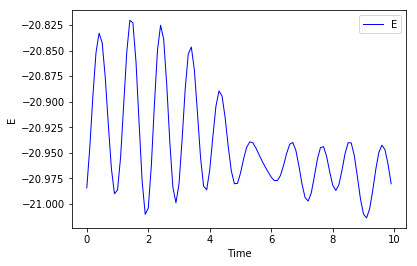

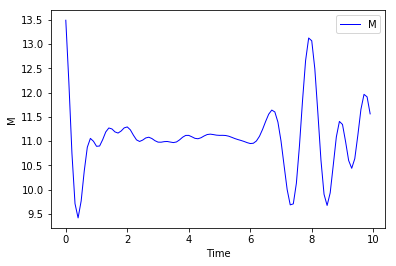

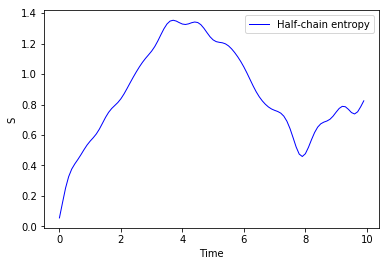

In [139]:
plt.plot(t, E, 'b', linewidth=1., label='E')
plt.legend()
plt.xlabel('Time', fontsize=10)
plt.ylabel('E', fontsize=10)
plt.show()

plt.plot(t, magnet, 'b', linewidth=1., label='M')
plt.legend()
plt.xlabel('Time', fontsize=10)
plt.ylabel('M', fontsize=10)
plt.show()

plt.plot(t, halfchain_entropy, 'b', linewidth=1., label='Half-chain entropy')
plt.legend()
plt.xlabel('Time', fontsize=10)
plt.ylabel('S', fontsize=10)
plt.show()

In [ ]:
chi_max = 30
eps = 1.e-10

dts = np.array([10**-i for i in range(1,6)])
N_steps = 10 * J
substep = 100
t = [0] * len(dts) * substep
E = []
magnet = []
halfchain_entropy = []

for i in range(len(dts)):
    l = i * substep
    U_bonds = tebd.calc_U_bonds(tising[2], 1j*dts[i])

    for j in range(substep): 
        # U_bonds[i] = expm(-dt*model.H_bonds[i]) -> dt: imaginary time
        tebd.run_TEBD(mps_spinup, U_bonds, N_steps, chi_max, eps) # evolve state psi in place
        
        t[l+j] = t[l+j-1] + dts[i] * N_steps
        E.append(tising[2].energy(mps_spinup))
        magnet.append(np.sum(mps_spinup.site_expectation_value(Sz)))
        halfchain_entropy.append(mps_spinup.entanglement_entropy()[L//2])
    
    print("t = %6.3f: E = %.3f, M = %.3f, S_halfchain = %.3f"
          % (t[l], E[l], magnet[l], halfchain_entropy[l]))

print("Final bond dimensions:", mps_spinup.get_chi())

In [ ]:
    if L < 20:  # for small systems compare to exact diagonalization
        E_exact = tfi_exact.finite_gs_energy(L, 1., g)
        print("Exact diagonalization: E = {E:.13f}".format(E=E_exact))
        print("relative error: ", abs((E - E_exact) / E_exact))
    return E, psi, model